In [1]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import ticker
#import path
import datetime
import time
import csv
import os
import pandas as pd
from lmfit.models import LinearModel, LorentzianModel, GaussianModel, ConstantModel, PseudoVoigtModel
import pwlf

# data-handling
from glob import glob
import fabio



In [2]:
filename = 'cell2'
expt_folder =  "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\" +filename
output = 'mar-'+filename
saved_1d_data = expt_folder + "\\1D_Data"
saved_figures = expt_folder + "\\saved_figures"
saved_fit_figures = saved_figures + "\\saved_fits"
condensed_save = expt_folder +'\\Condensed Data'
unified_save = 'H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\Condensed Data'
paperfolder = 'C:\\Users\\Natalie\\OneDrive - SLAC National Accelerator Laboratory\\Documents\\Research - Toney\\NRG papers\\Li Quantification\\figures'

area = 0.1963 #electrochemcially active area (cm^2)


echem_folder = "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\echem"
os.chdir(echem_folder)
time_periods = pd.read_pickle("./" + filename + "echem-cycle-times.pkl")
date_formatec = '%m/%d/%Y %H:%M:%S.%f'
date_format = '%Y-%m-%d %H:%M:%S'



cap_plated = time_periods['capacity'].iloc[1]
cap_stripped = time_periods['capacity'].iloc[3]


CE = cap_stripped/cap_plated
print('Coulombic Efficiency for cell: {} %'.format(CE*100))


Coulombic Efficiency for cell: 57.142323524661556 %


In [3]:
def line_fit(x, y, limits):
    line_mod = LinearModel(prefix='line_')
    pars = line_mod.make_params()
    out = line_mod.fit(y, pars, x=x)
    return out

    


In [4]:
os.chdir(condensed_save)
time_periods = pd.read_csv('echem_time_periods.csv')
scans =        pd.read_csv('scans.csv')
limits = []
start_time = datetime.datetime.strptime(time_periods["start time"].iloc[1], '%Y-%m-%d %H:%M:%S.%f')

total_df = pd.DataFrame(columns=['amplitude','width','center', 'fraction', 'background_l', 'slope', 'fit', 'scan_no', 'times','times_delta', 'times_delta_stage', 'times_since_prev_scan'])
fits_df = pd.DataFrame(columns=['slope', 'intercept'])


C:\Users\Natalie\Anaconda3\envs\py3-working\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


se [3.28854460e+04 1.09004782e+01 1.16935697e+01 1.21853007e+01
 1.22451538e+01]
[ 9.13454500e-08  3.52758916e+03 -3.66680449e+03 -4.05596854e+03
  4.17654873e+03]
{'slope': [0, 3527.589162324856, -139.21533212663917, -4195.183876030014, -18.635144254233637], 'intercept': array([9.13454500e-08, 1.27334846e+07, 1.02276086e+07, 1.62013672e+06,
       1.28470412e+06])}


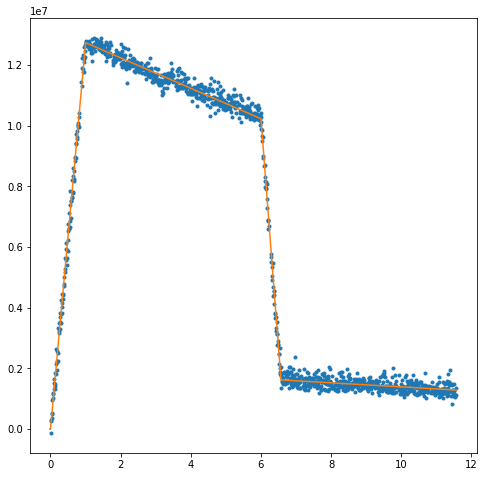

In [5]:
plt.close()
os.chdir(saved_1d_data)


limits = []
start_time = datetime.datetime.strptime(str(time_periods["start time"].iloc[1]), '%Y-%m-%d %H:%M:%S.%f')

#create empty dataframes
total_df = pd.DataFrame(columns=['amplitude','width','center', 'fraction', 'background_l',
                                 'slope', 'fit', 'scan_no', 
                                 'times','times_delta', 'times_delta_stage', 'times_since_prev_scan'])
fits_df = pd.DataFrame(columns=['slope', 'intercept'])



for i, stage in enumerate(time_periods.iloc[:,0]):
    if i==0: #this is before echem starts - all scans were summed to create background 
        fits = {'slope': [0],'intercept': [0]}  
        fits = pd.DataFrame(fits)
        fits_df = fits_df.append(pd.DataFrame(fits))
    
    
    if i>=1: #for each echem section Plate-OCV-Strip-OCV, loads fits place into full Data frame for entire experiemnt 
   
        
        os.chdir(saved_fit_figures)
        savename = str(stage) +'all_fits_df.csv'
        df = pd.read_csv(savename)    
        df = df[df['fit'] <= 1.2e17]
        
        
        times = []
        times_delta = []
        times_delta_stage = []
        times_since_prev_scan = []
        start_time_stage = datetime.datetime.strptime(str(time_periods["start time"].iloc[i]), '%Y-%m-%d %H:%M:%S.%f')
        
        for n, scan in enumerate(df['scan_no']):
            
            time = (scans['scan_times'].loc[scans['scans'] == int(scan)])
            time = datetime.datetime.strptime(time.values[0], date_format)
            times.append(time)

            time_delta_total = (time - start_time)
            time_delta_stage = (time - start_time_stage)
            times_delta.append(float(time_delta_total.total_seconds()))
            times_delta_stage.append(float(time_delta_stage.total_seconds()))
            if n == 0:
                time_since_prev_scan = 0.0
                times_since_prev_scan.append(time_since_prev_scan)
            else:
                time_since_prev_scan = (time - times[-2])
                times_since_prev_scan.append(float(time_since_prev_scan.total_seconds()))
                
                
        #create timepoints for each scan relative to start of experiment, stage, and previous scan
   
        df['times'] = pd.to_datetime(df['Unnamed: 0'] )
        df['times_delta'] = df['times'] - start_time
        df['times_delta_stage'] = df['times'] - start_time_stage
        df['times_since_prev_scan'] = (times_since_prev_scan)

        y = (df['amplitude'].values).astype(float)
        x = (df['times_delta_stage'].values).astype(float)
        
        #fit x and  y (time and intensity) with line fit in stage (not used in efficiency)
        out = line_fit(x, y, limits)
        fits = {'slope': [out.best_values['line_slope']],'intercept': [out.best_values['line_intercept']]}
        fits = pd.DataFrame(fits)
        fits_df = fits_df.append(pd.DataFrame(fits))

        newsave = os.path.join(condensed_save, str(stage) +'all_fits_df.csv')
        df.to_csv(newsave)
        total_df = total_df.append(df)
        

intensity = total_df['amplitude']

time_delta = total_df['times_delta']/datetime.timedelta(seconds=1)


#time and intensity with with piece wise function with breaks at stage breaks
start_time = datetime.datetime.strptime(str(time_periods["start time"].iloc[1]), '%Y-%m-%d %H:%M:%S.%f')
t0 = (start_time - start_time).total_seconds()
t1 = (datetime.datetime.strptime(str(time_periods["end time"].iloc[1]), '%Y-%m-%d %H:%M:%S.%f') - start_time).total_seconds()
t2 = (datetime.datetime.strptime(str(time_periods["end time"].iloc[2]), '%Y-%m-%d %H:%M:%S.%f') - start_time).total_seconds()
t3 = (datetime.datetime.strptime(str(time_periods["end time"].iloc[3]), '%Y-%m-%d %H:%M:%S.%f') - start_time).total_seconds()
t4 = (datetime.datetime.strptime(str(time_periods["end time"].iloc[4]), '%Y-%m-%d %H:%M:%S.%f') - start_time).total_seconds()

time_0 = [0.0]
intensity_0 = [0.0]
timepoints = ([t0, t1, t2, t3, t4])

piecewise_funct = pwlf.PiecewiseLinFit(time_delta.astype(float), intensity.values.astype(float))
res = piecewise_funct.fit_with_breaks_force_points(np.array(timepoints), time_0, time_0)

##create set of points and fit the intensity based on p-w function
time_fits = np.linspace(t0, t4, num=100)
intensity_fit = piecewise_funct.predict(np.array(time_fits))
intensity_fit_timepts = piecewise_funct.predict(time_delta)
intensity_fit_endpts = piecewise_funct.predict((timepoints))


#fitting parameters and Standard dev and error
pre_var = piecewise_funct.prediction_variance(time_fits)
sd_at_timepoints = np.sqrt(piecewise_funct.prediction_variance(timepoints))
sd = np.sqrt(pre_var)
se = piecewise_funct.standard_errors()

##plotting intensity fits and p-w fit (orange)
plt.figure(figsize=(8,8))
plt.plot(time_delta/3600,intensity, '.')

plt.errorbar(np.array(timepoints)/3600, intensity_fit_endpts, yerr=se)
print('se', se)
print(piecewise_funct.beta)


fits = {'slope': [out.best_values['line_slope']],'intercept': [out.best_values['line_intercept']]}
fits_pw = {'slope': [0,
                     piecewise_funct.beta[1], 
                    piecewise_funct.beta[1]+ piecewise_funct.beta[2],
                    piecewise_funct.beta[1]+ piecewise_funct.beta[2] + piecewise_funct.beta[3],
                    piecewise_funct.beta[1]+ piecewise_funct.beta[2] + piecewise_funct.beta[3] + piecewise_funct.beta[4]],
         'intercept': intensity_fit_endpts
         }
print(fits_pw)
fits_pw = pd.DataFrame(fits_pw)


In [6]:
e_chem_stages        = [(1,3)]
plating_stages       = [(1),]
stripping_stages     = [(3)]
corrosion_ocv_stages = [(2,4)]
cycles = [1]


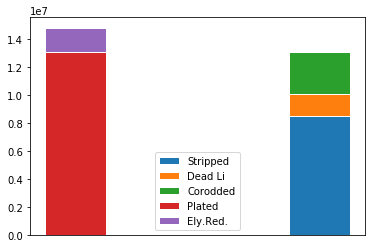

   Li_corroded_OCV0  Li_corroded_OCV1  Li_corroded_plating  Li_plated_app  \
1      2.505876e+06     335432.602167        318100.265063   1.273348e+07   

     Li_atstart     Li_plated  Li_corroded_stripping       Li_dead  \
1  9.134545e-08  1.305158e+07          153348.924648  1.620137e+06   

   Li_stripped_app   Li_stripped  ...           SEI      total_in  \
1     8.607472e+06  8.454123e+06  ...  1.743268e+06  1.479485e+07   

      total_out  cap_plated  cap_stripped             In      %Dead  \
1  1.305158e+07       0.098      0.055999  147948.533201  10.950678   

     %ElyRed  %stripped     %corr  
1  11.782938  57.142324  20.12406  

[1 rows x 22 columns]


"savepath = os.path.join(unified_save, output + '.csv')\nvalues.to_csv(savepath)\nsavepath = os.path.join(paperfolder, output + '.csv')\nvalues.to_csv(savepath)"

In [7]:
plt.close()
values = pd.DataFrame(columns=['Li_atstart', 'Li_plated', 'Li_plated_app', 'Li_stripped', 'Li_stripped_app',
                               'Li_corroded_OCV0','Li_corroded_OCV1', 
                               'Li_corroded_plating' ,'Li_corroded_stripping',
                               'Li_dead', 'SEI', 'Li_corroded_total', 'CE', 
                               'total_in', 'total_out', 'cap_plated', 'cap_stripped',
                               '%stripped', '%ElyRed', '%Dead', '%corr'
                              ])

corrosion_constants = {}


#from piecewise fit, find dead, electrolyte red (SEI), plated/stripped lithium 
for i, cycle in enumerate(cycles):
    values_cycle = {}
    
    for n, stage in enumerate(corrosion_ocv_stages[i]):
        corrosion_constants[str(stage)] = float(fits_pw['slope'].iloc[stage]/fits_pw['intercept'].iloc[stage])
        initial, final = intensity_fit_endpts[stage-1], intensity_fit_endpts[stage]
        dead2 = initial
        
        
        key = "Li_corroded_OCV" + str(n)
        values_cycle[key] = -(final-initial)

    corrosion_constants = pd.DataFrame(corrosion_constants, index=['cons'], dtype=(float))
    corrosion_constant = corrosion_constants.mean()

    
    for n, stage in enumerate(plating_stages):#[i]):
        os.chdir(condensed_save)
        savename = str(stage) +'all_fits_df.csv'
        df = pd.read_csv(savename)

        #find the amount of Li corroded in the plating phases
        corroded = df['amplitude']*df['times_since_prev_scan']*corrosion_constant[0]
        values_cycle['Li_corroded_plating'] = -corroded.sum(axis=0)
        
        
        #find the amount of Li plated in the plating phases
        initial, final = intensity_fit_endpts[0], intensity_fit_endpts[1]

        
        values_cycle['Li_plated_app'] = final - initial 
        values_cycle['Li_atstart'] = initial
        values_cycle['Li_plated'] = values_cycle['Li_plated_app'] + values_cycle['Li_corroded_plating']
        
    for n, stage in enumerate(stripping_stages):#[i]):
        os.chdir(condensed_save)
        savename = str(stage) +'all_fits_df.csv'
        df = pd.read_csv(savename)
        
        #find the amount of Li corroded in the stripping phases
        corroded = df['amplitude']*df['times_since_prev_scan']*corrosion_constant[0]
        values_cycle['Li_corroded_stripping'] = -corroded.sum(axis=0)
        
        #find the amount of Li stripped in the stripping phases
        initial, final = intensity_fit_endpts[2], intensity_fit_endpts[3]
        dead1 = final
        values_cycle['Li_dead'] = final 
        

        values_cycle['Li_stripped_app'] = -(final - initial)
                values_cycle['Li_stripped'] = values_cycle['Li_stripped_app'] - values_cycle['Li_corroded_stripping']
        

    values_cycle['Li_corroded_total'] =  (values_cycle['Li_corroded_OCV0'] 
                                          + values_cycle['Li_corroded_plating'] 
                                          + values_cycle['Li_corroded_stripping'])
    
    values_cycle['CE'] = CE 

    values_cycle['SEI'] = (((values_cycle['Li_stripped'])
                           -(values_cycle['CE']*values_cycle['Li_plated']))
                           /values_cycle['CE'])
                           
    
    
    values_cycle['total_in'] = values_cycle['SEI'] + values_cycle['Li_plated']
    values_cycle['total_out'] = values_cycle['Li_stripped'] + values_cycle['Li_dead'] + values_cycle['Li_corroded_total']
    values_cycle['cap_plated'] = cap_plated
    values_cycle['cap_stripped'] = cap_stripped
    
    values_cycle['In'] = (values_cycle['Li_stripped']/(cap_stripped/area))*(cap_plated/area)/100
    
    values_cycle['%Dead']     = values_cycle['Li_dead']/values_cycle['In']
    values_cycle['%ElyRed']   = values_cycle['SEI']/values_cycle['In']
    values_cycle['%stripped'] = values_cycle['Li_stripped']/values_cycle['In']
    values_cycle['%corr']     = values_cycle['Li_corroded_total']/values_cycle['In']
    
    
    plt.figure(i)
    width = 0.25
    #ind = np.arange(N)
    p11 = plt.bar([1], values_cycle['Li_stripped'], width, edgecolor='white')
    p21 = plt.bar([1], values_cycle['Li_dead'], width, bottom=values_cycle['Li_stripped'], edgecolor='white')
    p1_p21 = (values_cycle['Li_stripped'] + values_cycle['Li_dead'])
    
    p31 = plt.bar([1], values_cycle['Li_corroded_total'], width, bottom=p1_p21, edgecolor='white')
    p1_p2_p31 = ((values_cycle['Li_stripped'] +
                  values_cycle['Li_dead']
                  + values_cycle['Li_corroded_total']))
    
    p12 = plt.bar([0], values_cycle['Li_plated'], width, edgecolor='white')
    p22 = plt.bar([0], values_cycle['SEI'], width, bottom = values_cycle['Li_plated'], edgecolor='white')
    p1_p22 = (values_cycle['Li_plated'] + values_cycle['SEI'])

    plt.legend((p11[0], p21[0], p31[0], p12[0], p22[0]), ('Stripped', 'Dead Li', 'Corodded', 'Plated', 'Ely.Red.'))
    plt.xticks([])
    save = os.path.join(unified_save, (output + ' - ' + str(cycle) + ' intensities.png'))
    #plt.savefig(save)
    plt.show()
    
    values_cycle = pd.DataFrame(values_cycle, index=([str(cycle)]))

    values = values.append(values_cycle)
    print(values_cycle)
        
    
    
"""savepath = os.path.join(unified_save, output + '.csv')
values.to_csv(savepath)
savepath = os.path.join(paperfolder, output + '.csv')
values.to_csv(savepath)"""



In [8]:
plt.close()

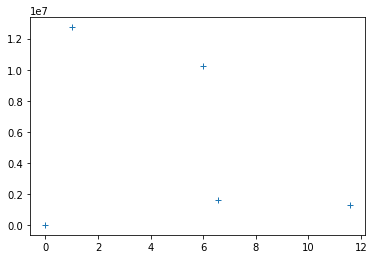

[0.0, 1.0027035833333333, 6.00269063888889, 6.572634527777778, 11.572621166666666]
2019-03-30 09:54:13.421600


In [9]:
##plot overlaying the extrapolated Dead, plated, stripped, corrosion


calced_x = [(datetime.datetime.strptime(time_periods["start time"].iloc[1], '%Y-%m-%d %H:%M:%S.%f')-start_time).total_seconds()/3600,
     (datetime.datetime.strptime(time_periods["start time"].iloc[2], '%Y-%m-%d %H:%M:%S.%f')-start_time).total_seconds()/3600,
     (datetime.datetime.strptime(time_periods["start time"].iloc[3], '%Y-%m-%d %H:%M:%S.%f')-start_time).total_seconds()/3600,
     (datetime.datetime.strptime(time_periods["start time"].iloc[4], '%Y-%m-%d %H:%M:%S.%f')-start_time).total_seconds()/3600,
     (datetime.datetime.strptime(time_periods["end time"].iloc[4], '%Y-%m-%d %H:%M:%S.%f')-start_time).total_seconds()/3600
     ]
calced_y = [0, 
     values_cycle['Li_plated_app']                                 +values_cycle['Li_atstart'], 
     values_cycle['Li_plated_app']                                 +values_cycle['Li_atstart']-values_cycle['Li_corroded_OCV0'], 
     values_cycle['Li_dead'],
            #values_cycle['Li_plated_app']-values_cycle['Li_corroded_OCV0']-values_cycle['Li_stripped'],
     values_cycle['Li_dead']-values_cycle['Li_corroded_OCV1']
           ]
plt.figure()            
plt.plot(calced_x,calced_y, '+')

calced_x_withcorr = [(datetime.datetime.strptime(time_periods["start time"].iloc[2], '%Y-%m-%d %H:%M:%S.%f')-start_time).total_seconds()/3600,
                     (datetime.datetime.strptime(time_periods["start time"].iloc[4], '%Y-%m-%d %H:%M:%S.%f')-start_time).total_seconds()/3600,

                    ]
calced_y_withcorr = [values_cycle['Li_plated'],
                     values_cycle['Li_dead'] + values_cycle['Li_corroded_stripping']
                    ]
plt.show()
print(calced_x)
print(start_time)

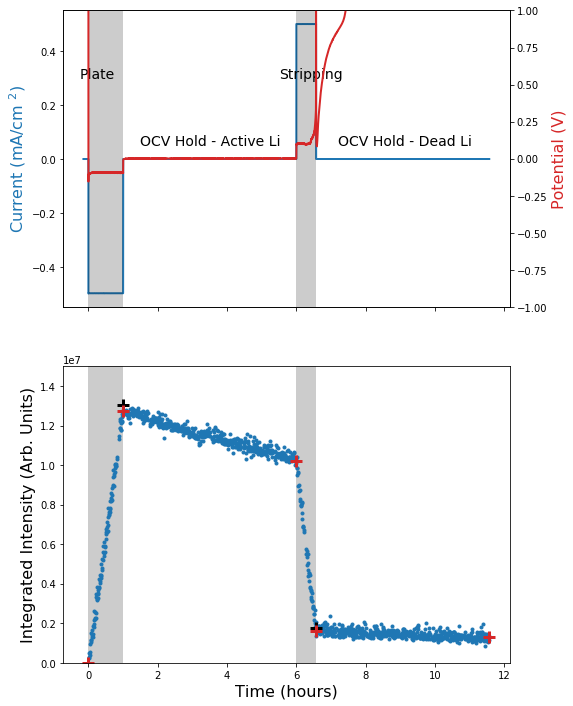

<Figure size 576x504 with 0 Axes>

"save = os.path.join(paperfolder, (output + 'fits plus echem.png'))\nf.savefig(save)"

In [10]:
#plot of echem and intensity through time

os.chdir(echem_folder)


echem_filename = glob("*" + filename + "*.txt")
echem_file = echem_filename[0]


ec_data = pd.read_csv(echem_file, delimiter='\t')
time_abs  = ec_data['time/s']
potential = ec_data['Ewe/V']
current   = ec_data['<I>/mA']
time_translated = (pd.to_datetime(time_abs, format=date_formatec))

#find the start and end times
last =   len(time_translated)-1
end_time =   time_translated[last]

#convert time into time since beginning of expt
time_delta_ec = pd.to_timedelta(time_translated - start_time) / np.timedelta64(1, 's')
currentdens = current/area


f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8,12))
plt.figure(figsize=(8,7))
ax1.plot(time_delta_ec/3600., currentdens,color = 'C0', linewidth='2')
ax1.set_ylabel('Current (mA/cm $\mathregular{^2}$)', color = 'C0', fontsize=16)
#ax1.set_ylim(-2,2)
#ax1.set_xlim(0,7.5)

ax3 = ax1.twinx()
ax3.plot(time_delta_ec/3600., potential,    color = 'C3', linewidth='2')
ax3.set_ylabel('Potential (V)',  color = 'C3', fontsize=16)
ax3.set_ylim(-1,1)
#ax3.set_xlim(0,7.5)
ax3.tick_params('y', )


ax2.plot(time_delta/3600,intensity,'o',  linewidth='2', markersize=3)
#ax2.plot(calced_x,calced_y, '+', mew=3, markersize=12)
ax2.set_xlabel('Time (hours)', fontsize=16)
ax2.set_ylabel('Integrated Intensity (Arb. Units)', fontsize=16)
#ax2.set_xlim(0,)
ax2.set_ylim(0,1.5e7)


ax2.axvspan(calced_x[0], calced_x[1], facecolor='k', alpha=0.2)
ax2.axvspan(calced_x[2], calced_x[3], facecolor='k', alpha=0.2)
ax3.axvspan(calced_x[0], calced_x[1], facecolor='k', alpha=0.2)
ax3.axvspan(calced_x[2], calced_x[3], facecolor='k', alpha=0.2)

ax1.text(-0.25,0.3, ('Plate'), fontsize=14)
ax1.text(1.5,0.05, ('OCV Hold - Active Li'), fontsize=14)
ax1.text(5.5,0.3, ('Stripping'), fontsize=14)
ax1.text(7.2,0.05, ('OCV Hold - Dead Li'), fontsize=14)


"""save = os.path.join(paperfolder, (output + 'intensity plus echem.png'))
f.savefig(save)"""




ax2.plot(calced_x_withcorr,calced_y_withcorr, '+', mew=3, markersize=12, color='k')
ax2.plot(calced_x,calced_y, '+', mew=3, markersize=12, color='C3')
#plt.tight_layout() 
plt.show()
"""save = os.path.join(paperfolder, (output + 'fits plus echem.png'))
f.savefig(save)"""


In [11]:
plt.close()

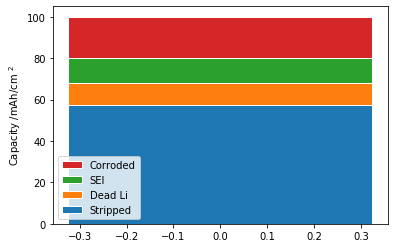

"save = os.path.join(unified_save, (output + 'stacked eff.png'))\nplt.savefig(save)"

In [14]:
#bar plot of all % efficiency to 100 of stripped, corrosion, dead Li, and electrolyte reduction

plt.close()

plt.gcf()
N = 1
width = 0.65


In = (values_cycle['Li_stripped']/(cap_stripped/area))*(cap_plated/area)/100

ind = np.arange(N)
p1 = plt.bar(ind, values_cycle['Li_stripped']/In, width, edgecolor='white')
p2 = plt.bar(ind, values_cycle['Li_dead']/In, width, bottom=values_cycle['Li_stripped']/In, edgecolor='white')
p1_p2 = (values_cycle['Li_stripped'] + values_cycle['Li_dead'])/In

p3 = plt.bar(ind, values_cycle['SEI']/In, width, bottom=p1_p2, edgecolor='white')
p1_p2_p3 = (values_cycle['Li_stripped'] + values_cycle['Li_dead'] + values_cycle['SEI'])/In

p4 = plt.bar(ind, values_cycle['Li_corroded_total']/In, width, bottom=p1_p2_p3, edgecolor='white')

plt.legend((p4[0], p3[0], p2[0], p1[0]), ('Corroded', 'SEI', 'Dead Li', 'Stripped'))
plt.ylabel('Capacity /mAh/cm $\mathregular{^2}$')
plt.gcf()
plt.show()

"""save = os.path.join(unified_save, (output + 'stacked eff.png'))
plt.savefig(save)"""

In [17]:
#finding the corrosion current and loss rate constant

corrosion_pw ={}

for n, stage in enumerate(corrosion_ocv_stages[0]):
    os.chdir(condensed_save)
    
    key = "slope_" + str(n)
    
    
    corrosion_pw[key] = float(fits_pw['slope'].iloc[stage])
    
    key = "intercept_" + str(n) 
    corrosion_pw[key] = float(fits_pw['intercept'].iloc[stage])
    key = "corr_constant_" + str(n) 
    corrosion_pw[key] = float(fits_pw['slope'].iloc[stage]/fits_pw['intercept'].iloc[stage])
    corrosion_pw['intensity stripped'] = values_cycle['Li_stripped'][0]
    corrosion_pw['e_stripped'] = cap_stripped
    corrosion_pw['e_plated'] = cap_plated
    
#print(corrosion_pw)
corrosion_pw = pd.DataFrame(corrosion_pw, index = ['cycle1'])
print(corrosion_pw)

savepath = os.path.join(unified_save, output + 'corrosion.csv')
corrosion_pw.to_csv(savepath)

           slope_0   intercept_0  corr_constant_0  intensity stripped  \
cycle1 -139.215332  1.022761e+07        -0.000014        8.454123e+06   

        e_stripped  e_plated    slope_1   intercept_1  corr_constant_1  
cycle1    0.055999     0.098 -18.635144  1.284704e+06        -0.000015  
